***What should I cook tonight? ***

In [6]:
!pip install selenium
!apt-get update
!apt install -y chromium-browser chromium-chromedriver
!pip install pandas

import sys
import time
import re
import random
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.common.exceptions import (
    NoSuchElementException,
    TimeoutException,
    StaleElementReferenceException,
    ElementClickInterceptedException,
)
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC


Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Ign:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pack

In [31]:
chrome_options = Options()
chrome_options.add_argument('--headless')  # Headless mode
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--disable-gpu')
chrome_options.add_argument('--window-size=1920x1080')
chrome_options.binary_location = '/usr/bin/chromium-browser'

driver = webdriver.Chrome(options=chrome_options)

def safe_click(element):
    try:
        element.click()
    except (ElementClickInterceptedException, StaleElementReferenceException):
        driver.execute_script("arguments[0].click();", element)

def safe_find_element(by, value, context=driver, timeout=10):
    try:
        return WebDriverWait(context, timeout).until(EC.presence_of_element_located((by, value)))
    except TimeoutException:
        return None

def safe_find_elements(by, value, context=driver, timeout=10):
    try:
        return WebDriverWait(context, timeout).until(EC.presence_of_all_elements_located((by, value)))
    except TimeoutException:
        return []


In [32]:
# Collecting Recipe Links from 5 Pages in reccipe index
recipe_links = []
max_pages = 5

driver.get('https://www.skinnytaste.com/recipe-index/')
time.sleep(2)

current_page = 1

while current_page <= max_pages:
    print(f"Collecting links from page {current_page}")

    links_on_page = []
    recipe_elements = safe_find_elements(By.CSS_SELECTOR, 'article.post')
    for article in recipe_elements:
        link_element = safe_find_element(By.CSS_SELECTOR, 'h2.entry-title a', context=article)
        if link_element:
            href = link_element.get_attribute('href')
            if href not in recipe_links:
                recipe_links.append(href)
                links_on_page.append(href)

    print(f"Collected {len(links_on_page)} links from page {current_page}")
    try:
        # Find the 'Next' button
        next_button = safe_find_element(By.CSS_SELECTOR, 'a.facetwp-page.next')
        if next_button and next_button.get_attribute('data-page'):
            safe_click(next_button)
            time.sleep(2)
            current_page += 1
        else:
            print("No more pages found.")
            break
    except Exception as e:
        print(f"Error navigating to the next page: {e}")
        break

print(f"Total recipe links collected: {len(recipe_links)}")

Collected 20 links from page 1
Collected 20 links from page 2
Collected 20 links from page 3
Collected 20 links from page 4
Collected 20 links from page 5
Total recipe links collected: 100


In [8]:
# Selecting 50 random links
if len(recipe_links) < 50:
    print(f"Collected {len(recipe_links)} recipe links instead of 50.")
    selected_links = recipe_links
else:
    selected_links = random.sample(recipe_links, 50)

with open('selected_recipe_links.txt', 'w') as f:
    for link in selected_links:
        f.write(f"{link}\n")

print("50 Recipe pages are saved to 'selected_recipe_links.txt'")

50 Recipe pages are saved to 'selected_recipe_links.txt'


**Step1 – Webscraping**

In [9]:
# Scrapng from Each Recipe
names = []
images = []
calories_list = []
personal_points_list = []
summaries = []
recipe_keys = []

for idx, recipe_link in enumerate(selected_links):
    try:
        print(f"Processing recipe {idx+1}/{len(selected_links)}: {recipe_link}")
        driver.get(recipe_link)
        time.sleep(2)

        # Extract Name
        name = ''
        name_element = safe_find_element(By.TAG_NAME, 'h1')
        if name_element:
            name = name_element.text.strip()
        else:
            name_element = safe_find_element(By.CSS_SELECTOR, 'div.recipe-title')
            if name_element:
                name = name_element.text.strip()
            else:
                print("Name element not found for this recipe.")
                name = 'The Magical Recipe'

        # Extract Image URL
        image_url = ''
        image_element = safe_find_element(By.CSS_SELECTOR, 'figure.wp-block-image img')
        if not image_element:
            image_element = safe_find_element(By.CSS_SELECTOR, 'img.wp-block-image')
        image_url = image_element.get_attribute('src') if image_element else ''

        # Extract Calories
        calories = ''
        span_elements = safe_find_elements(By.TAG_NAME, 'span')
        for span in span_elements:
            text = span.text
            if 'Calories' in text:
                calories = text.replace('Calories:', '').strip()
                calories = re.sub('[^0-9]', '', calories)
                break

        # Extract Description Summary
        description = ''
        description_element = safe_find_element(By.CSS_SELECTOR, 'div.entry-content p')
        if description_element:
            description = description_element.text.strip()

        # Extract Recipe Tags/keys
        tags = ''
        tag_list = safe_find_elements(By.CSS_SELECTOR, 'ul.cat-icons.post-icons li')
        if tag_list:
            tags = ' '.join([tag.text.strip() for tag in tag_list])
        else:
            tag_elements = safe_find_elements(By.CSS_SELECTOR, 'span.recipe-key')
            if tag_elements:
                tags = ' '.join([tag.text.strip() for tag in tag_elements])

        # Extract Personal Points
        points = ''
        points_element = safe_find_element(By.CSS_SELECTOR, 'span.recipe-meta-value.recipe-ww-pp.icon')
        if points_element:
            points = points_element.text.strip()
        else:
            content_elements = safe_find_elements(By.CSS_SELECTOR, 'div.entry-content p')
            for element in content_elements:
                text = element.text
                if 'PersonalPoints' in text:
                    points_match = re.search(r'(\d+)\s*PersonalPoints', text)
                    if points_match:
                        points = points_match.group(1)
                        break

        names.append(name)
        images.append(image_url)
        calories_list.append(calories)
        personal_points_list.append(points)
        summaries.append(description)
        recipe_keys.append(tags)

    except Exception as e:
        print(f"Error processing recipe: {e}")
        names.append(name if name else 'The Magical Recipe')
        images.append(image_url if image_url else '')
        calories_list.append(calories if calories else '')
        personal_points_list.append(points if points else '')
        summaries.append(description if description else '')
        recipe_keys.append(tags if tags else '')
        continue

driver.quit()

Processing recipe 1/50: https://www.skinnytaste.com/apple-butter-recipe/
Processing recipe 2/50: https://www.skinnytaste.com/high-protein-oat-waffles/
Processing recipe 3/50: https://www.skinnytaste.com/red-curry-salmon/
Processing recipe 4/50: https://www.skinnytaste.com/skinny-chicken-tikka-masala/
Processing recipe 5/50: https://www.skinnytaste.com/grilled-salmon-with-avocado-bruschetta/
Processing recipe 6/50: https://www.skinnytaste.com/asian-grilled-chicken-33-pts_3510/
Processing recipe 7/50: https://www.skinnytaste.com/thai-fried-rice-575-pts/
Processing recipe 8/50: https://www.skinnytaste.com/strawberry-yogurt-bark/
Processing recipe 9/50: https://www.skinnytaste.com/roasted-delicata-squash/
Processing recipe 10/50: https://www.skinnytaste.com/applesauce-nut-bread/
Processing recipe 11/50: https://www.skinnytaste.com/lobster-rolls/
Processing recipe 12/50: https://www.skinnytaste.com/one-pot-chicken-and-orzo/
Processing recipe 13/50: https://www.skinnytaste.com/lighter-chicke

**Step 2 – Filter interesting data**

In [10]:
# Create DataFrame
data = {
    'Name': names,
    'Image': images,
    'Calories': calories_list,
    'Points': personal_points_list,
    'Description': summaries,
    'Tags': recipe_keys
}

df = pd.DataFrame(data)

df['Calories'] = pd.to_numeric(df['Calories'], errors='coerce')
df['Points'] = pd.to_numeric(df['Points'], errors='coerce')
df.to_csv('skinnytaste_recipes.csv', index=False)

print("Data saved to 'skinnytaste_recipes.csv'")
print(df.head())

Data saved to 'skinnytaste_recipes.csv'
                                     Name  \
0                            Apple Butter   
1                         Protein Waffles   
2                        Red Curry Salmon   
3                    Chicken Tikka Masala   
4  Grilled Salmon Bruschetta with Avocado   

                                               Image  Calories  Points  \
0  https://www.skinnytaste.com/wp-content/uploads...      34.0     1.0   
1  https://www.skinnytaste.com/wp-content/uploads...     121.0     3.0   
2  https://www.skinnytaste.com/wp-content/uploads...     349.0     6.0   
3  https://www.skinnytaste.com/wp-content/uploads...     249.0     1.0   
4  https://www.skinnytaste.com/wp-content/uploads...       NaN     3.0   

                                         Description          Tags  
0  This easy apple butter recipe simmers on the s...    DF GF KF V  
1  These high protein waffles are made with cotta...  GF HP KF Q V  
2  Thai-inspired Red Curry Salmon is 

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [12]:
df = pd.read_csv('skinnytaste_recipes.csv')
print("DataFrame Shape:", df.shape)
print("DataFrame Columns:", df.columns)
df.head()

DataFrame Shape: (50, 6)
DataFrame Columns: Index(['Name', 'Image', 'Calories', 'Points', 'Description', 'Tags'], dtype='object')


,Name,Image,Calories,Points,Description,Tags
0,Apple Butter,https://www.skinnytaste.com/wp-content/uploads...,34.0,1.0,This easy apple butter recipe simmers on the s...,DF GF KF V
1,Protein Waffles,https://www.skinnytaste.com/wp-content/uploads...,121.0,3.0,These high protein waffles are made with cotta...,GF HP KF Q V
2,Red Curry Salmon,https://www.skinnytaste.com/wp-content/uploads...,349.0,6.0,Thai-inspired Red Curry Salmon is simmered in ...,DF GF HP
3,Chicken Tikka Masala,https://www.skinnytaste.com/wp-content/uploads...,249.0,1.0,This easy Chicken Tikka Masala is made with te...,GF HP MP Q
4,Grilled Salmon Bruschetta with Avocado,https://www.skinnytaste.com/wp-content/uploads...,NaN,3.0,NaN,GF HP LC Q W


**Step 3 – EDA and Visualisation **

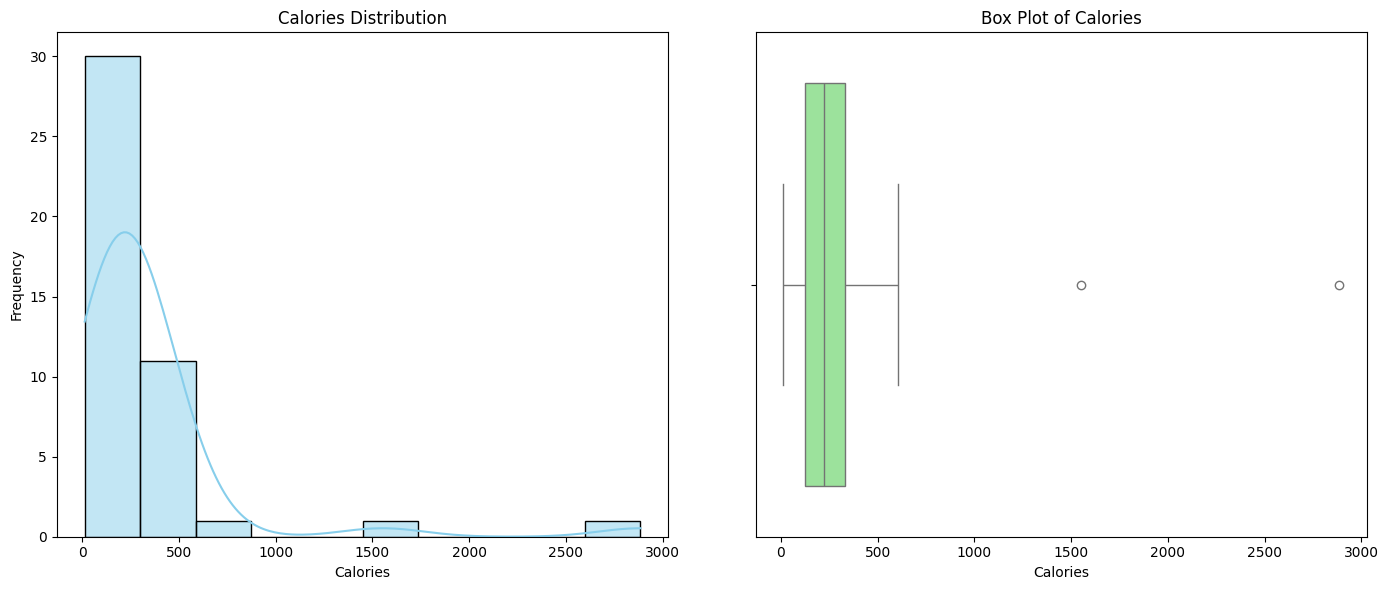

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

# Plot 1: Histogram with KDE (on the left)
sns.histplot(df['Calories'], bins=10, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Calories Distribution')
axes[0].set_xlabel('Calories')
axes[0].set_ylabel('Frequency')

# Plot 2: Box Plot (on the right)
sns.boxplot(x=df['Calories'], color='lightgreen', ax=axes[1])
axes[1].set_title('Box Plot of Calories')
axes[1].set_xlabel('Calories')

plt.tight_layout(w_pad=5)
plt.show()


<ipython-input-69-a5bb49943347>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tags_df, x='Tag', y='Count', palette='viridis')


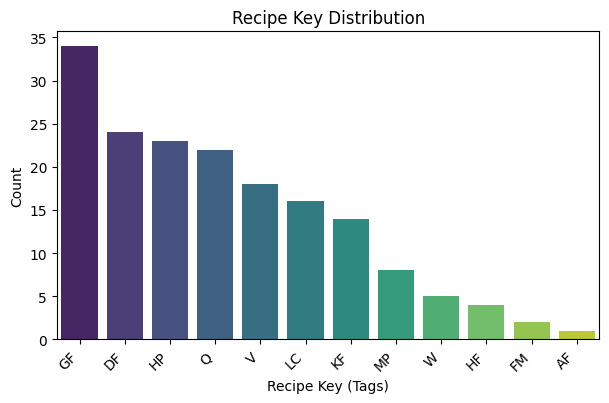

In [69]:
df_tags = df.dropna(subset=['Tags']).copy()
df_tags['Tags List'] = df_tags['Tags'].str.split()
all_tags = [tag for tags_list in df_tags['Tags List'] for tag in tags_list]

from collections import Counter
tag_counts = Counter(all_tags)

tags_df = pd.DataFrame.from_dict(tag_counts, orient='index', columns=['Count'])
tags_df = tags_df.reset_index().rename(columns={'index': 'Tag'})
tags_df = tags_df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(7, 4))
sns.barplot(data=tags_df, x='Tag', y='Count', palette='viridis')
plt.title('Recipe Key Distribution')
plt.xlabel('Recipe Key (Tags)')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.show()


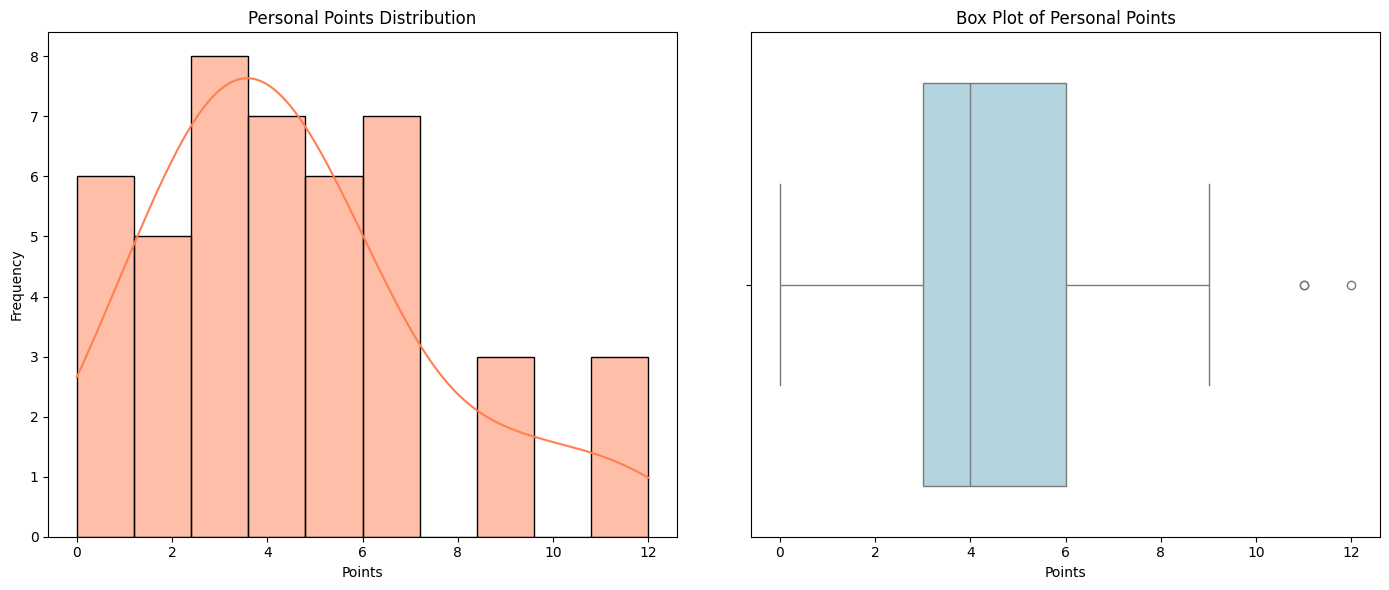

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

df_points = df.dropna(subset=['Points'])
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

# Plot 1: Histogram with KDE (on the left)
sns.histplot(df_points['Points'], bins=10, kde=True, color='coral', ax=axes[0])
axes[0].set_title('Personal Points Distribution')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Frequency')

# Plot 2: Box Plot (on the right)
sns.boxplot(x=df_points['Points'], color='lightblue', ax=axes[1])
axes[1].set_title('Box Plot of Personal Points')
axes[1].set_xlabel('Points')

plt.tight_layout(w_pad=5)
plt.show()


<ipython-input-61-dd51b6a58b25>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tag_calories_df, x='Tag', y='Calories', palette='coolwarm', ax=axes[1])


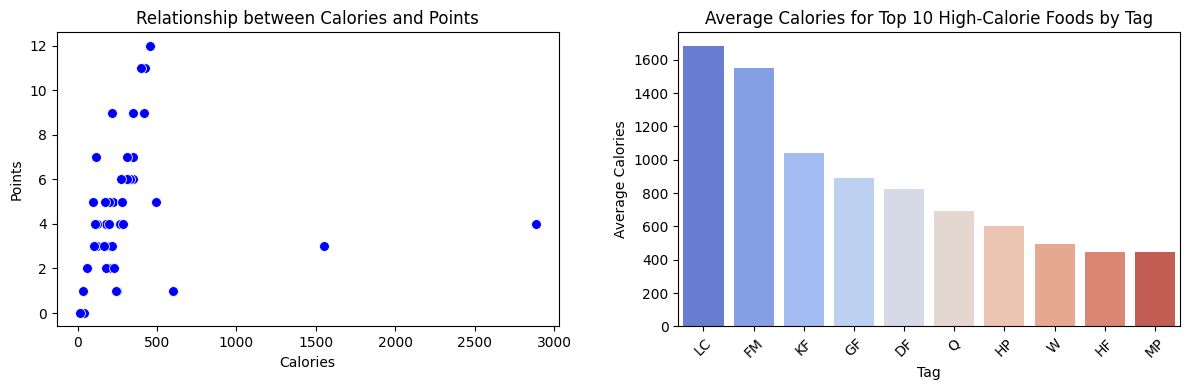

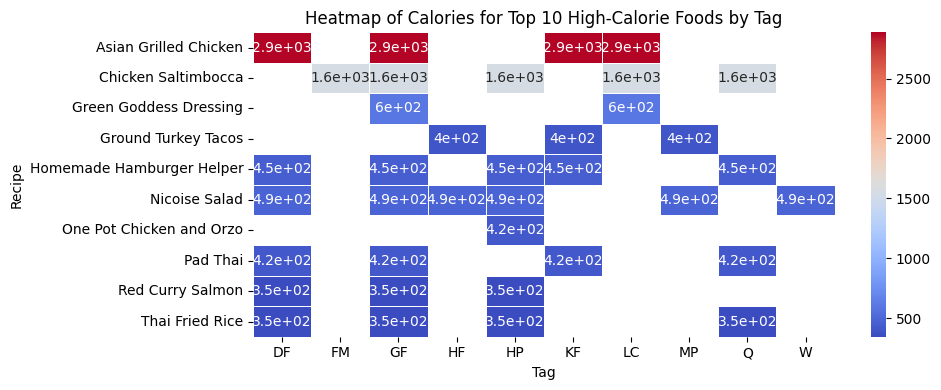

In [61]:

df_filtered = df.dropna(subset=['Calories', 'Points'])
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

# Plot 1: Scatter plot of Calories vs Points (left side)
sns.scatterplot(data=df_filtered, x='Calories', y='Points', color='blue', s=50, ax=axes[0])
axes[0].set_title('Relationship between Calories and Points')
axes[0].set_xlabel('Calories')
axes[0].set_ylabel('Points')

# Plot 2: Bar plot for Average Calories per Tag for Top 10 High-Calorie Foods (right side)
sns.barplot(data=tag_calories_df, x='Tag', y='Calories', palette='coolwarm', ax=axes[1])
axes[1].set_title('Average Calories for Top 10 High-Calorie Foods by Tag')
axes[1].set_xlabel('Tag')
axes[1].set_ylabel('Average Calories')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout(w_pad=3)
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))

# Plot 3: Heatmap for Calories vs Tags in Top 10 High-Calorie Foods
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=0.5, ax=ax)
ax.set_title('Heatmap of Calories for Top 10 High-Calorie Foods by Tag')
ax.set_xlabel('Tag')
ax.set_ylabel('Recipe')

plt.tight_layout()
plt.show()


<ipython-input-65-2852d180f059>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=word_df, x='Word', y='Count', palette='coolwarm')


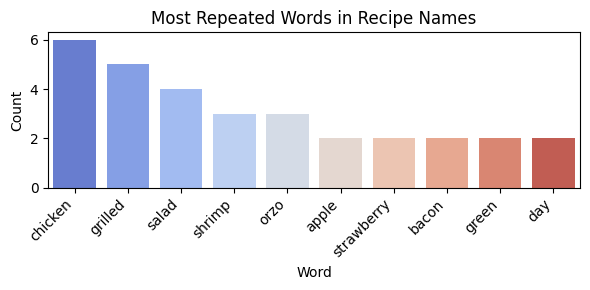

In [65]:
all_words = ' '.join(df['Name'].dropna()).lower()
words = re.findall(r'\b\w+\b', all_words)
word_counts = Counter(words)

stopwords = set(['the', 'and', 'to', 'of', 'a', 'in', 'with', 'for', 'on', 'recipe', 'this', 'is'])
word_counts = {word: count for word, count in word_counts.items() if word not in stopwords}

word_df = pd.DataFrame(list(word_counts.items()), columns=['Word', 'Count'])
word_df = word_df.sort_values(by='Count', ascending=False).head(10)  # Top 10 most frequent words

# Bar plot showing the most repeated words in recipe names with smaller figure size
plt.figure(figsize=(6, 3))
sns.barplot(data=word_df, x='Word', y='Count', palette='coolwarm')
plt.title('Most Repeated Words in Recipe Names')
plt.xlabel('Word')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Step 4 – User interaction**

In [63]:
from IPython.display import display, HTML, Image

def get_numeric_input(prompt):
    while True:
        try:
            value = float(input(prompt))
            return value
        except ValueError:
            print("Invalid input. Please enter a numeric value.")

def get_tag_input(all_tags):
    print("\nAvailable Tags:")
    print(", ".join(all_tags))
    selected_tags = input("\nEnter tags separated by commas, or type 'all' to select all tags: ").lower().split(',')
    selected_tags = [tag.strip() for tag in selected_tags if tag.strip()]

    if 'all' in selected_tags:
        return all_tags
    else:
        return [tag for tag in selected_tags if tag in all_tags]

# calorie range
print("Please enter the calorie range:")
cal_min = get_numeric_input("Minimum calories: ")
cal_max = get_numeric_input("Maximum calories: ")

#Ensuring minimum < maximum.
if cal_min > cal_max:
    cal_min, cal_max = cal_max, cal_min
    print("Ensuring minimum < maximum.")

# Points range
print("\nPlease enter the Personal Points range:")
points_min = get_numeric_input("Minimum Points: ")
points_max = get_numeric_input("Maximum Points: ")

if points_min > points_max:
    points_min, points_max = points_max, points_min
    print("Ensuring minimum < maximum.")

df_tags = df.dropna(subset=['Tags']).copy()
all_tags_list = list(set([tag.strip().lower() for tags in df_tags['Tags'] for tag in tags.split()]))
selected_tags = get_tag_input(all_tags_list)

# Filtering DataFrame
filtered_df = df.dropna(subset=['Calories', 'Points']).copy()
filtered_df = filtered_df[filtered_df['Tags'].apply(lambda x: any(tag in x.lower() for tag in selected_tags))]
filtered_df = filtered_df[
    (filtered_df['Calories'] >= cal_min) & (filtered_df['Calories'] <= cal_max) &
    (filtered_df['Points'] >= points_min) & (filtered_df['Points'] <= points_max)
]
filtered_df = filtered_df.sort_values(by='Calories')

# Getting first 10 recipes
top_recipes = filtered_df.head(10).reset_index(drop=True)

def display_recipes(recipes_df):
    for idx, row in recipes_df.iterrows():
        print(f"Recipe {idx+1}: {row['Name']}")
        print(f"Calories: {row['Calories']}")
        print(f"Points: {row['Points']}")
        print(f"Tags: {row['Tags']}")
        print(f"Description: {row['Description']}")
        # Display image if available
        if pd.notna(row['Image']) and row['Image']:
            display(Image(url=row['Image'], width=300))
        else:
            print("No image available.")
        print("\n" + "-"*50 + "\n")

if top_recipes.empty:
    print("No recipes found matching the specified criteria.")
else:
    display_recipes(top_recipes)


Please enter the calorie range:
Minimum calories: 1
Maximum calories: 1000

Please enter the Personal Points range:
Minimum Points: 1
Maximum Points: 5

Available Tags:
hp, gf, q, hf, lc, v, mp, w, af, kf, df, fm

Enter tags separated by commas, or type 'all' to select all tags: all
Recipe 1: Apple Butter
Calories: 34.0
Points: 1.0
Tags: DF GF KF V
Description: This easy apple butter recipe simmers on the stove, made with apples, cinnamon, nutmeg, and allspice, it smells and tastes like fall!



--------------------------------------------------

Recipe 2: Strawberry Yogurt Bark
Calories: 60.0
Points: 2.0
Tags: DF GF KF V
Description: If you’re looking for a healthy snack with some added protein for the kids this summer, you’ll love this strawberry yogurt bark!



--------------------------------------------------

Recipe 3: Bacon in the Oven
Calories: 60.0
Points: 2.0
Tags: DF GF HP KF LC Q W
Description: Whether you’re a fan of tender, crisp, or extra crispy bacon, this simple method of cooking bacon in the oven is easy. There’s no stovetop mess, and it frees up your stove for cooking other breakfast items!



--------------------------------------------------

Recipe 4: Red, White and Blueberry Cheesecake Cupcakes
Calories: 98.0
Points: 5.0
Tags: V
Description: Easy Cheesecake cupcakes made with cream cheese, Greek yogurt with a vanilla wafer crust topped with strawberries and blueberries.



--------------------------------------------------

Recipe 5: Baked Honey-Mustard Ham
Calories: 106.0
Points: 3.0
Tags: DF GF LC
Description: This easy, 4-ingredient Honey-Mustard Ham recipe is made with honey, Dijon mustard, and a touch of brown sugar on a baked spiral ham.



--------------------------------------------------

Recipe 6: Grilled Eggplant with Feta
Calories: 106.0
Points: 3.0
Tags: GF LC Q V
Description: If you need an easy side dish this summer, this grilled eggplant with feta cheese is great with anything you’re grilling.



--------------------------------------------------

Recipe 7: Blueberry Zucchini Bread
Calories: 111.0
Points: 4.0
Tags: FM KF V
Description: This moist and delicious Blueberry Zucchini Bread is low-fat, lightly sweetened, and loaded with summer zucchini and blueberries. Perfect for breakfast or as a snack!



--------------------------------------------------

Recipe 8: Protein Waffles
Calories: 121.0
Points: 3.0
Tags: GF HP KF Q V
Description: These high protein waffles are made with cottage cheese, oat flour and eggs. So good you’ll never make them any other way!



--------------------------------------------------

Recipe 9: Apple Bread
Calories: 124.0
Points: 4.0
Tags: V
Description: Moist cinnamon apple bread recipe made with applesauce, small chunks of fresh apples and walnuts in every bite. It’s so moist and delicious, you won’t believe it’s light!



--------------------------------------------------

Recipe 10: Cucumber Soup
Calories: 169.0
Points: 3.0
Tags: GF LC V
Description: A refreshing and light cold Cucumber Soup made with Greek yogurt and fresh herbs. It’s easy to make, no cooking or heating the kitchen, making it perfect for a hot summer day.



--------------------------------------------------





---



---

                                                      **The End**